In [5]:
import time
import pandas as pd
import json
import re
import nltk
import ast
import networkx as nx
import community  # pip install python-louvain
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Load the saved JSON file
with open("reddit_vangogh_final3.json", "r", encoding="utf-8") as f:
    all_data = json.load(f)

# Convert it into a DataFrame
df = pd.DataFrame(all_data)

# Display the first 5 rows
print(df.head())


   source subreddit platform_id  \
0  reddit       Art      674ffr   
1  reddit       Art      674ffr   
2  reddit       Art      674ffr   
3  reddit       Art      674ffr   
4  reddit       Art      674ffr   

                                          post_title  \
0  Why is Van Gogh so famous when his art looks a...   
1  Why is Van Gogh so famous when his art looks a...   
2  Why is Van Gogh so famous when his art looks a...   
3  Why is Van Gogh so famous when his art looks a...   
4  Why is Van Gogh so famous when his art looks a...   

                                           post_text  \
0  I posted this in AskReddit before, but it was ...   
1  I posted this in AskReddit before, but it was ...   
2  I posted this in AskReddit before, but it was ...   
3  I posted this in AskReddit before, but it was ...   
4  I posted this in AskReddit before, but it was ...   

                                            post_url       post_timestamp  \
0  https://www.reddit.com/r/Art/commen

In [25]:
# Load your raw JSON file — update path if needed
with open("reddit_vangogh_final3.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

print("Loaded", len(raw_data), "top-level comments.")

Loaded 23771 top-level comments.


In [27]:
# Build the graph
G = nx.DiGraph()
G.add_edges_from(edges_df.values)

# Convert to undirected for Louvain
G_undirected = G.to_undirected()

# Run Louvain
partition = community.best_partition(G_undirected)

# Assign community labels
nx.set_node_attributes(G_undirected, partition, "community")

# Summary of detected communities
community_counts = Counter(partition.values())
print("Number of communities detected:", len(community_counts))
print("Top 5 community sizes:", community_counts.most_common(5))


Number of communities detected: 563
Top 5 community sizes: [(1, 468), (514, 99), (217, 76), (248, 64), (236, 62)]


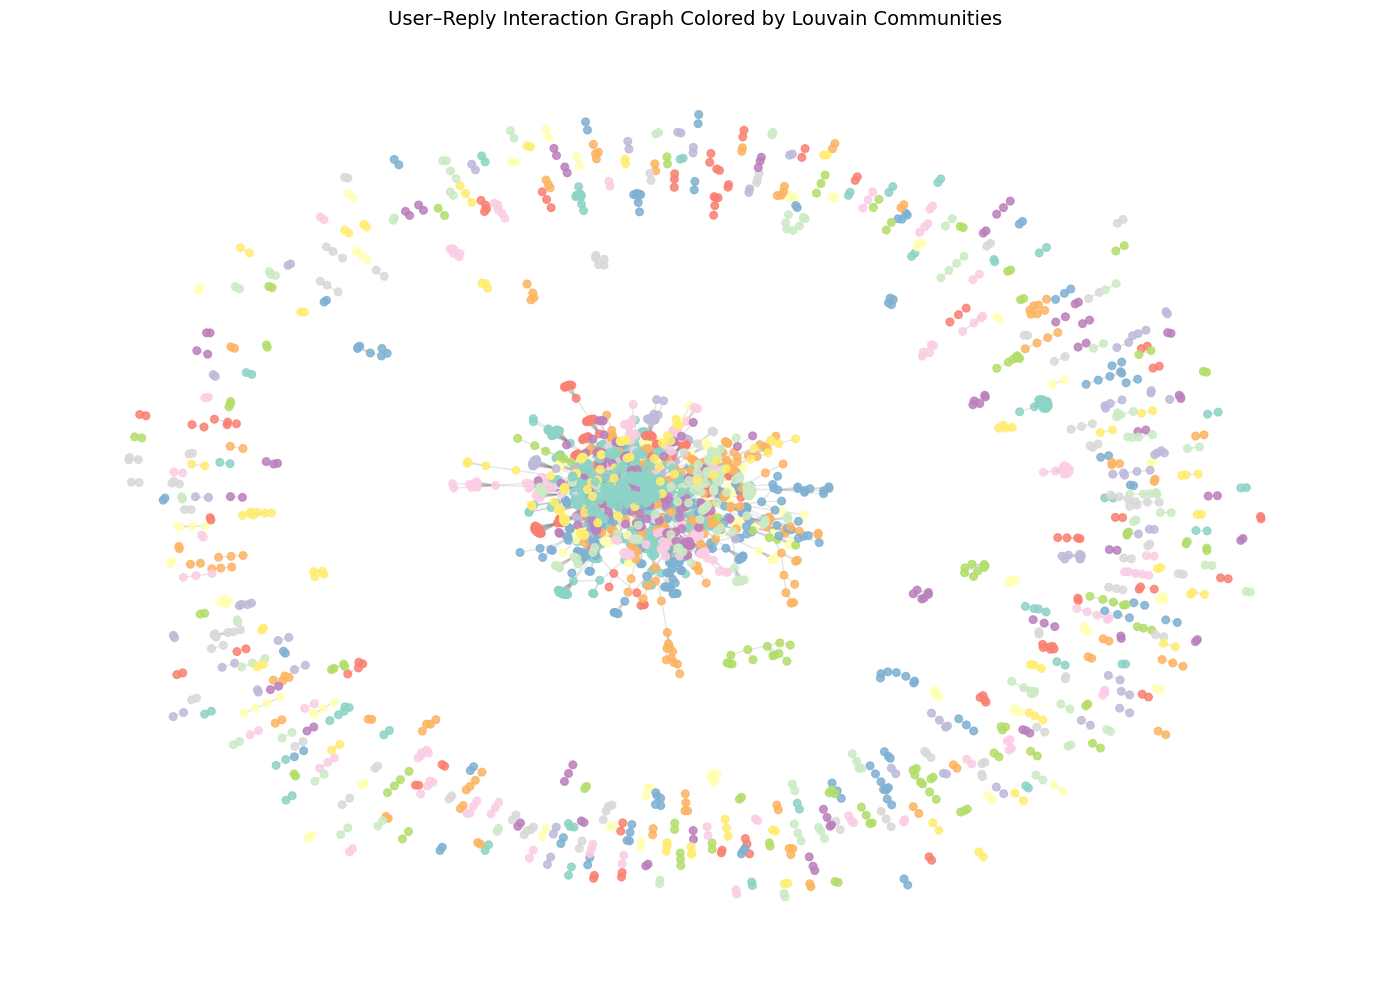

In [36]:
# Generate layout for consistent visual spacing
pos = nx.spring_layout(G_undirected, seed=42)  # or nx.kamada_kawai_layout for smoother output

#Extract community for coloring
community_values = [partition.get(node) for node in G_undirected.nodes()]

#Plot
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=30,
    node_color=community_values,
    cmap=plt.cm.Set3,  # distinct colors for each community
    alpha=0.85
)
nx.draw_networkx_edges(
    G_undirected, pos,
    alpha=0.2,
    edge_color="gray"
)
plt.title("User–Reply Interaction Graph Colored by Louvain Communities", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [28]:
nx.write_gexf(G_undirected, "vangogh_reply_graph.gexf")
print("Graph saved as vangogh_reply_graph.gexf")

Graph saved as vangogh_reply_graph.gexf


In [29]:
partition_df = pd.DataFrame(partition.items(), columns=["user", "community"])

# Compute Degree Centrality
deg_centrality = nx.degree_centrality(G_undirected)
deg_df = pd.DataFrame(deg_centrality.items(), columns=["user", "degree_centrality"])

# Merge with community info
centrality_df = partition_df.merge(deg_df, on="user")

# Show top users in each of top 3 largest communities
top_communities = centrality_df['community'].value_counts().head(3).index.tolist()
top_users_per_community = centrality_df[centrality_df['community'].isin(top_communities)]
top_users_per_community = top_users_per_community.sort_values(by="degree_centrality", ascending=False)

top_users_per_community.groupby("community").head(5)

,user,community,degree_centrality
3,deleted,1,0.185053
2780,b214n,514,0.010353
1165,Anonymous-USA,217,0.008088
2733,SomanydynamoS,514,0.004529
2806,JBgreen,514,0.004529
2854,J-G_Wentworth,514,0.003559
1434,ayoitsjo,217,0.002912
2822,rpifireman,514,0.002588
1331,deputygus,217,0.001941
1815,vintagefairy4,217,0.001618


In [45]:
# Extended stopwords set
stopwords = {
    "the", "and", "is", "to", "of", "a", "i", "in", "it", "that", "was", "for", "on", "this", "with",
    "as", "but", "not", "have", "are", "at", "be", "you", "he", "she", "they", "we", "his", "her", "their",
    "my", "me", "your", "so", "s", "t", "m", "d", "ll", "ve", "re", "just", "or", "if", "can", "about", "from"
}

def get_cleaned_keywords(texts, n=10):
    all_words = []
    for text in texts:
        words = text.lower().split()
        words = [w for w in words if w not in stopwords and len(w) > 2]
        all_words.extend(words)
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

# Top communities
top_coms_filtered = cleaned_comments_df['community'].value_counts().head(5).index.tolist()

# Print cleaned keywords
for com in top_coms_filtered:
    texts = cleaned_comments_df[cleaned_comments_df['community'] == com]['final_cleaned'].tolist()
    top_words = get_cleaned_keywords(texts)
    print(f"\n🔹 Cleaned top words in Community {int(com)}:")
    for word, count in top_words:
        print(f"  {word}: {count}")



🔹 Cleaned top words in Community 1:
  like: 1029
  art: 792
  van: 783
  [deleted]: 694
  it's: 652
  one: 646
  think: 639
  will: 553
  what: 525
  all: 524

🔹 Cleaned top words in Community 437:
  will: 168
  think: 140
  like: 98
  because: 91
  some: 84
  music: 77
  i'm: 70
  don't: 70
  way: 63
  all: 63

🔹 Cleaned top words in Community 217:
  van: 188
  one: 139
  art: 136
  gogh: 102
  vincent: 95
  would: 85
  him: 83
  lhermitte: 82
  more: 79
  think: 77

🔹 Cleaned top words in Community 2:
  dog: 104
  he’s: 64
  thank: 58
  one: 58
  all: 50
  love: 48
  it’s: 42
  much: 42
  art: 40
  how: 40

🔹 Cleaned top words in Community 25:
  van: 313
  gogh: 216
  one: 141
  art: 117
  see: 99
  how: 98
  because: 96
  painting: 92
  paintings: 91
  had: 91


In [53]:
# Step 1: Extract nodes from Community 217
target_community = 217
community_217_nodes = [node for node, data in G_undirected.nodes(data=True) if data.get("community") == target_community]

# Step 2: Create subgraph
G_217 = G_undirected.subgraph(community_217_nodes).copy()

# Step 3: Export to Gephi
nx.write_gexf(G_217, "community_217.gexf")
print("Exported Community 217 subgraph to 'community_217.gexf'")

Exported Community 217 subgraph to 'community_217.gexf'


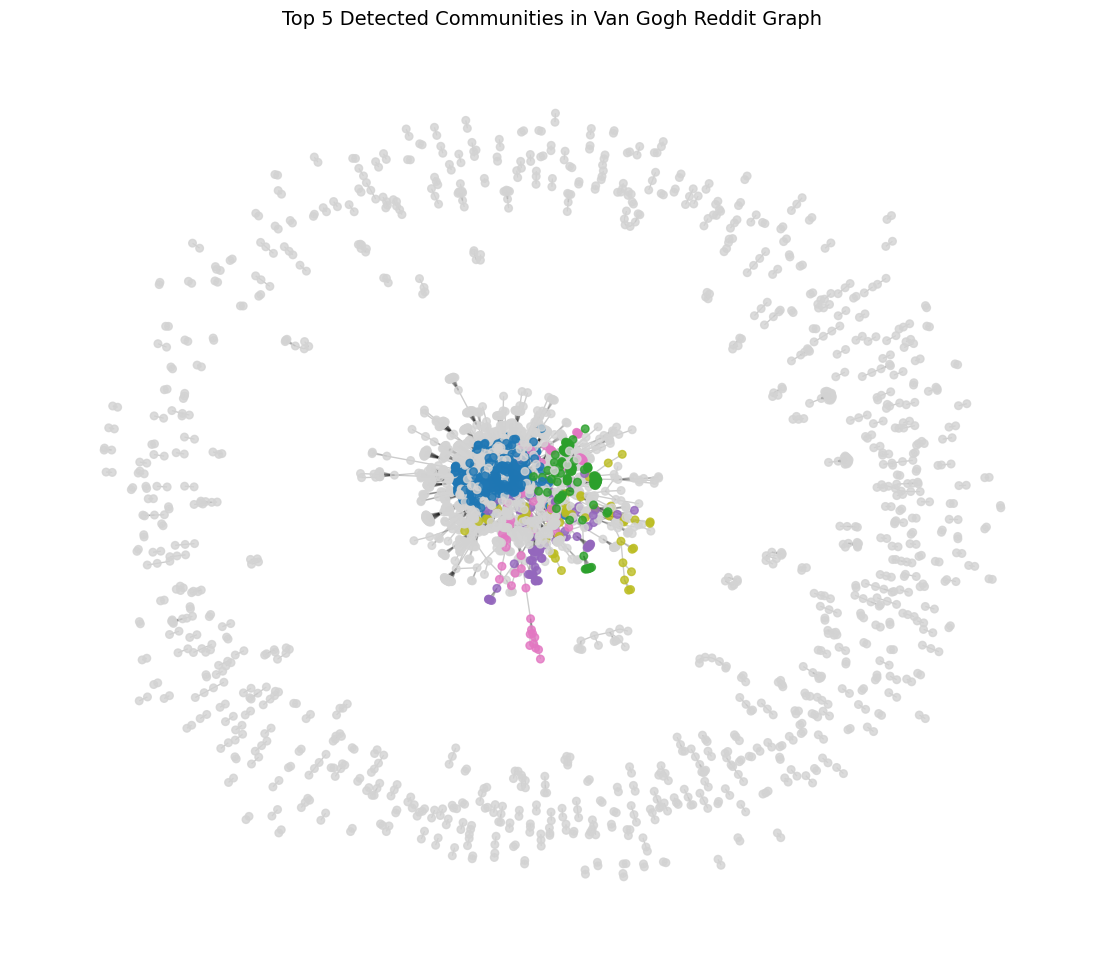

In [44]:
# Convert to undirected graph for Louvain
G_undirected = G.to_undirected()

# Run Louvain algorithm
partition = community.best_partition(G_undirected)

# Get top 5 communities
community_counts = Counter(partition.values())
top_5_coms = [com for com, count in community_counts.most_common(5)]

# Assign color to top 5 communities, others = gray
color_map = []
for node in G_undirected:
    community_id = partition[node]
    if community_id in top_5_coms:
        color_index = top_5_coms.index(community_id) / 5
        color_map.append(cm.tab10(color_index))  # distinct color
    else:
        color_map.append('#d3d3d3')  # light gray

# Draw the graph
pos = nx.spring_layout(G_undirected, seed=42)
plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G_undirected, pos, node_color=color_map, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.2)
plt.title("Top 5 Detected Communities in Van Gogh Reddit Graph", fontsize=14)
plt.axis("off")
plt.show()


In [48]:
# Example function from your existing logic
stopwords = {
    "the", "and", "is", "to", "of", "a", "i", "in", "it", "that", "was", "for", "on", "this", "with",
    "as", "but", "not", "have", "are", "at", "be", "you", "he", "she", "they", "we", "his", "her", "their",
    "my", "me", "your", "so", "s", "t", "m", "d", "ll", "ve", "re", "just", "or", "if", "can", "about", "from"
}

def get_cleaned_keywords(texts, n=10):
    all_words = []
    for text in texts:
        words = text.lower().split()
        words = [w for w in words if w not in stopwords and len(w) > 2]
        all_words.extend(words)
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

# Get top communities
top_coms_filtered = cleaned_comments_df['community'].value_counts().head(5).index.tolist()

# Extract and format top words per community
rows = []

for com in top_coms_filtered:
    texts = cleaned_comments_df[cleaned_comments_df['community'] == com]['final_cleaned'].tolist()
    top_words = get_cleaned_keywords(texts)
    keyword_string = ', '.join([f"{word}: {count}" for word, count in top_words])
    rows.append({'Community': int(com), 'Top Keywords': keyword_string})

#Create DataFrame and display
final_keywords_df = pd.DataFrame(rows)
display(final_keywords_df)

,Community,Top Keywords
0,1,"like: 1029, art: 792, van: 783, [deleted]: 694..."
1,437,"will: 168, think: 140, like: 98, because: 91, ..."
2,217,"van: 188, one: 139, art: 136, gogh: 102, vince..."
3,2,"dog: 104, he’s: 64, thank: 58, one: 58, all: 5..."
4,25,"van: 313, gogh: 216, one: 141, art: 117, see: ..."


In [54]:
# Filter only Community 217 comments
community_217_df = cleaned_comments_df[cleaned_comments_df['community'] == 217].copy()
print("Number of comments in Community 217:", community_217_df.shape[0])
community_217_df.head()

Number of comments in Community 217: 576


,user,final_cleaned,community
2054,AlexandriaLitehouse,It's really interesting to see how many times ...,217.0
2932,AlexandriaLitehouse,It's really interesting to see how many times ...,217.0
5340,AlexandriaLitehouse,It's really interesting to see how many times ...,217.0
7455,AlexandriaLitehouse,It's really interesting to see how many times ...,217.0
14174,AlexandriaLitehouse,It's really interesting to see how many times ...,217.0


In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment scoring
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

community_217_df['sentiment'] = community_217_df['final_cleaned'].apply(get_sentiment)
community_217_df['sentiment'].value_counts()


sentiment
Positive    315
Neutral     166
Negative     95
Name: count, dtype: int64

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


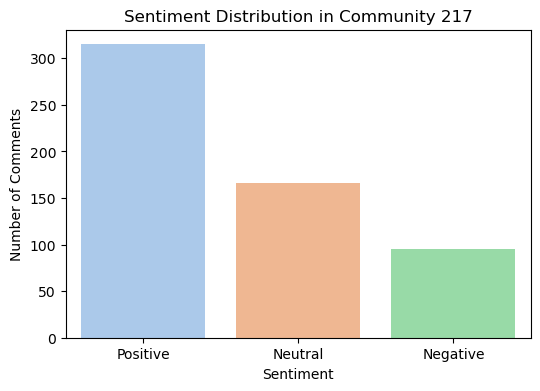

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=community_217_df, x='sentiment', palette='pastel')
plt.title('Sentiment Distribution in Community 217')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()


In [57]:
from collections import Counter

# Define extended stopwords
stopwords = set([
    "the", "and", "is", "to", "of", "a", "i", "in", "it", "that", "was", "for", "on", "this", "with",
    "as", "but", "not", "have", "are", "at", "be", "you", "he", "she", "they", "we", "his", "her", "their",
    "my", "me", "your", "so", "s", "t", "m", "d", "ll", "ve", "re", "just", "or", "if", "can", "about", "from"
])

words = " ".join(community_217_df['final_cleaned']).lower().split()
filtered_words = [w for w in words if w not in stopwords and len(w) > 2]
word_freq = Counter(filtered_words)
top_words = word_freq.most_common(20)

# Convert to DataFrame for display
import pandas as pd
keywords_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
keywords_df


,Word,Frequency
0,van,188
1,one,139
2,art,136
3,gogh,102
4,vincent,95
5,would,85
6,him,83
7,lhermitte,82
8,more,79
9,think,77


In [63]:
print(df.columns)


Index(['source', 'subreddit', 'platform_id', 'post_title', 'post_text',
       'post_url', 'post_timestamp', 'comment_id', 'parent_id', 'timestamp',
       'depth', 'author', 'text', 'score', 'hashtags', 'replies'],
      dtype='object')


Number of comments in Community 217: 576


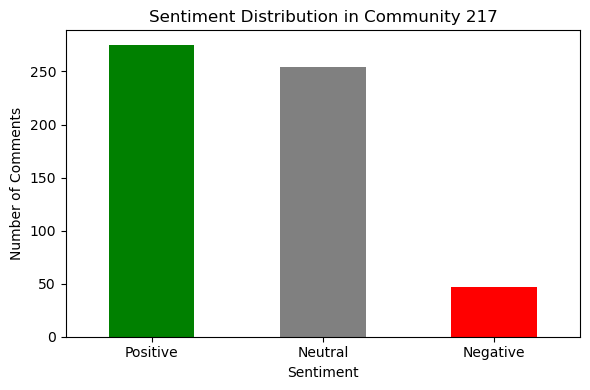

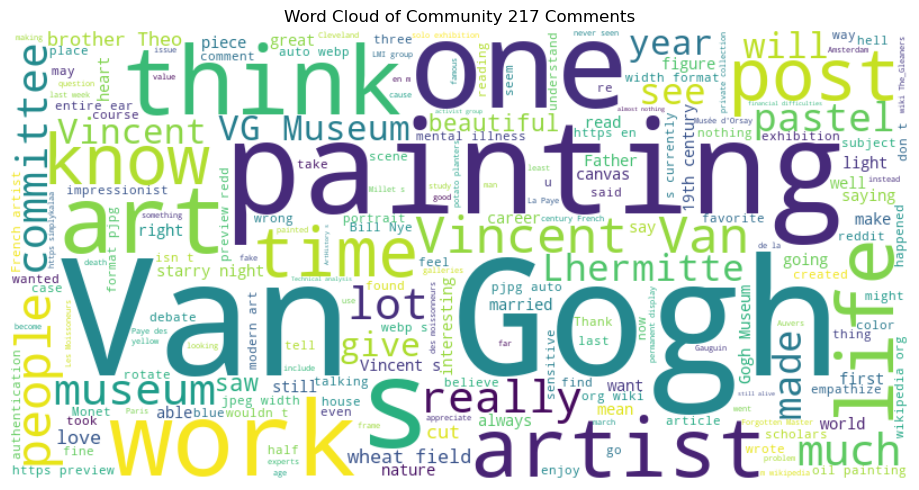

In [72]:
# Step 1: Filter comments from Community 217
community_217_df = cleaned_comments_df[cleaned_comments_df['community'] == 217].copy()
print("Number of comments in Community 217:", community_217_df.shape[0])

# Step 2: Perform sentiment analysis using TextBlob
from textblob import TextBlob

def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

community_217_df['sentiment'] = community_217_df['final_cleaned'].apply(get_sentiment_polarity)

def label_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

community_217_df['sentiment_label'] = community_217_df['sentiment'].apply(label_sentiment)

# Step 3: Plot sentiment distribution
import matplotlib.pyplot as plt

sentiment_counts = community_217_df['sentiment_label'].value_counts()
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Sentiment Distribution in Community 217")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 4: Word Cloud of comments
from wordcloud import WordCloud

all_text = ' '.join(community_217_df['final_cleaned'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Community 217 Comments")
plt.tight_layout()
plt.show()


In [67]:
# Filter comments mentioning "lhermitte"
lhermitte_comments = community_217_df[community_217_df['final_cleaned'].str.contains("lhermitte", case=False, na=False)]

# Count sentiment labels
sentiment_counts = lhermitte_comments['sentiment_label'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Display the sentiment breakdown
print("Sentiment distribution for comments mentioning 'Lhermitte':")
display(sentiment_counts)


Sentiment distribution for comments mentioning 'Lhermitte':


,Sentiment,Count
0,Positive,20
1,Neutral,6


C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


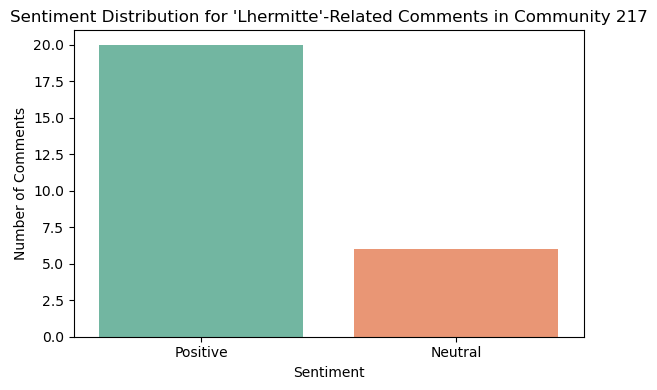

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, palette='Set2')
plt.title("Sentiment Distribution for 'Lhermitte'-Related Comments in Community 217")
plt.ylabel("Number of Comments")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()


In [84]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment
cleaned_comments_df['sentiment'] = cleaned_comments_df['final_cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Group by community
community_sentiment = cleaned_comments_df.groupby('community')['sentiment'].agg(['mean', 'min', 'max', 'count']).reset_index()
community_sentiment = community_sentiment.sort_values(by='mean', ascending=False)
community_sentiment.head()


,community,mean,min,max,count
293,293.0,0.97350,0.9577,0.9893,6
182,182.0,0.95640,0.9451,0.9677,2
235,235.0,0.92795,0.8799,0.9760,18
251,251.0,0.88155,0.7717,0.9914,2
136,136.0,0.87980,0.7818,0.9778,4


Total number of detected communities: 563
Top 10 Communities by User Count:


,Community,Number of Users
0,1.0,7352
1,437.0,679
2,217.0,576
3,2.0,526
4,25.0,479
5,248.0,439
6,236.0,436
7,344.0,396
8,34.0,287
9,39.0,257


<Figure size 1000x600 with 0 Axes>

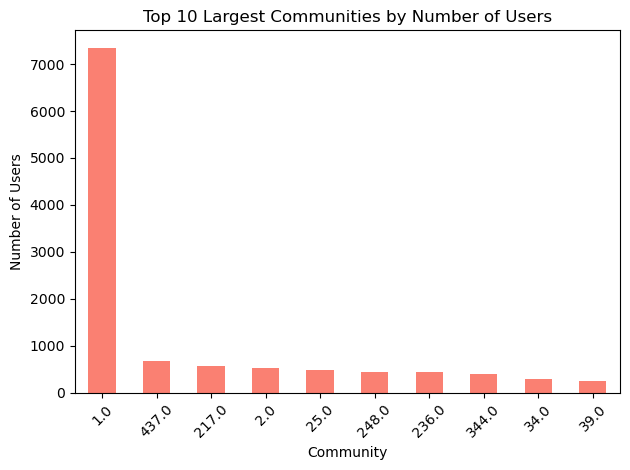

In [88]:
# Replace with your correct DataFrame that includes the 'community' column
df_with_community = cleaned_comments_df  # or final_df, depending on your notebook

# Step 1: Community Size Stats
community_counts = df_with_community['community'].value_counts().sort_values(ascending=False)
num_communities = community_counts.shape[0]
print(f"Total number of detected communities: {num_communities}")

# Step 2: Create summary table of top 10 communities
top_communities = community_counts.head(10).reset_index()
top_communities.columns = ['Community', 'Number of Users']
print("Top 10 Communities by User Count:")
display(top_communities)

# Step 3: Plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_communities.plot(kind='bar', x='Community', y='Number of Users', legend=False, color='salmon')
plt.title("Top 10 Largest Communities by Number of Users")
plt.ylabel("Number of Users")
plt.xlabel("Community")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
